In [1]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import Input, models, layers, optimizers, metrics
from tensorflow.keras.layers import Dense, Flatten, Activation, Dropout
from tensorflow.keras.applications import VGG16
from tensorflow.keras.callbacks import EarlyStopping

import numpy as np
import matplotlib.pyplot as plt

In [2]:
!git clone https://github.com/taehojo/data-ch20.git

Cloning into 'data-ch20'...
remote: Enumerating objects: 265, done.
remote: Counting objects: 100% (265/265), done.
remote: Compressing objects: 100% (265/265), done.
remote: Total 265 (delta 0), reused 265 (delta 0), pack-reused 0
Receiving objects: 100% (265/265), 1.86 MiB | 7.75 MiB/s, done.


In [3]:
train_datagen = ImageDataGenerator(rescale=1./255,
                                   horizontal_flip=True,
                                   width_shift_range=0.1,
                                   height_shift_range=0.1,)

In [4]:
train_generator = train_datagen.flow_from_directory(
    './data-ch20/train',
    target_size = (150, 150),
    batch_size=5,
    class_mode='binary'
)

Found 160 images belonging to 2 classes.


In [6]:
test_datagen=ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(
    './data-ch20/test',
    target_size = (150, 150),
    batch_size=5,
    class_mode='binary'
)

Found 120 images belonging to 2 classes.


In [7]:
transfer_model = VGG16(weights='imagenet', include_top=False, input_shape=(150, 150, 3))
transfer_model.trainable = False

58900480/58889256 [==============================] - 0s 0us/step


In [8]:
finetune_model = models.Sequential()
finetune_model.add(transfer_model)
finetune_model.add(Flatten())
finetune_model.add(Dense(64))
finetune_model.add(Activation('relu'))
finetune_model.add(Dropout(0.5))
finetune_model.add(Dense(1))
finetune_model.add(Activation('sigmoid'))
finetune_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 4, 4, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 8192)              0         
                                                                 
 dense (Dense)               (None, 64)                524352    
                                                                 
 activation (Activation)     (None, 64)                0         
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                                 
 activation_1 (Activation)   (None, 1)                 0

In [9]:
finetune_model.compile(loss='binary_crossentropy', optimizer=optimizers.Adam(learning_rate=0.0002), metrics=['accuracy'])

In [10]:
early_stopping_callback = EarlyStopping(monitor='val_loss', patience=5)

In [11]:
history = finetune_model.fit(
    train_generator,
    epochs=20,
    validation_data=test_generator,
    validation_steps=10,
    callbacks=[early_stopping_callback]
)

Epoch 1/20
32/32 [==============================] - 61s 2s/step - loss: 0.7202 - accuracy: 0.5625 - val_loss: 0.5856 - val_accuracy: 0.6200
Epoch 2/20
32/32 [==============================] - 70s 2s/step - loss: 0.5519 - accuracy: 0.7063 - val_loss: 0.4546 - val_accuracy: 0.9400
Epoch 3/20
32/32 [==============================] - 53s 2s/step - loss: 0.5018 - accuracy: 0.7812 - val_loss: 0.4625 - val_accuracy: 0.8400
Epoch 4/20
32/32 [==============================] - 47s 1s/step - loss: 0.4145 - accuracy: 0.8375 - val_loss: 0.3749 - val_accuracy: 0.7800
Epoch 5/20
32/32 [==============================] - 49s 2s/step - loss: 0.3598 - accuracy: 0.8750 - val_loss: 0.4405 - val_accuracy: 0.8400
Epoch 6/20
32/32 [==============================] - 47s 1s/step - loss: 0.3898 - accuracy: 0.8562 - val_loss: 0.3276 - val_accuracy: 0.9400
Epoch 7/20
32/32 [==============================] - 48s 2s/step - loss: 0.2919 - accuracy: 0.9125 - val_loss: 0.3049 - val_accuracy: 0.8800
Epoch 8/20
32/32 [==

In [12]:
y_vloss = history.history['val_loss']
y_loss = history.history['loss']

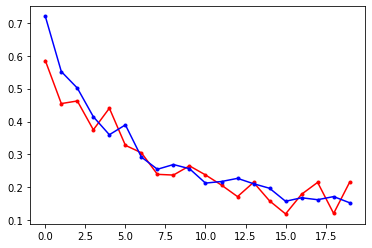

In [13]:
x_len = np.arange(len(y_loss))
plt.plot(x_len, y_vloss, marker='.', c='red', label='Testset_loss')
plt.plot(x_len, y_loss, marker='.', c='blue', label='Testset_loss')

plt.legend(loc='upper right')
plt.grid()
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()